# NLP Project

*Team members*:
- Asja Attanasio
- Daniele Laganà
- Marcello Martini
- Gianluigi Palmisano

# ⬇️ Import Dataset

Each record has three features:
- context
- question
- answer

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset

/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset using the Hugging Face datasets library
dataset = load_dataset("neural-bridge/rag-dataset-12000")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 2400
    })
})

In [4]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [5]:
train_df.head()

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...


In [6]:
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Columns:", train_df.columns)

Train set size: 9600
Test set size: 2400
Columns: Index(['context', 'question', 'answer'], dtype='object')


# 🔎 Data exploration

In [7]:
# Count rows with at least one missing value in 'context', 'question', or 'answer'
missing_rows_train = train_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()
missing_rows_test = test_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()

print("Rows with at least one missing value in train set:", missing_rows_train)
print("Rows with at least one missing value in test set:", missing_rows_test)

# Remove null values
train_df = train_df.dropna()
test_df = test_df.dropna()

Rows with at least one missing value in train set: 2
Rows with at least one missing value in test set: 1


In [8]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize lists and variables for analysis
context_lengths = []
question_lengths = []
vocab = set()
all_tokens = []

# Function to preprocess text
def preprocess(text):
    """Tokenize, lowercase, remove punctuation and stopwords from text."""
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]  # Keep only alphanumeric tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Function to process a single entry
def process_entry(entry):
    """Process a single dataset entry to extract tokens and update statistics."""
    context_tokens = preprocess(entry['context'])
    question_tokens = preprocess(entry['question'])
    
    # Update lengths
    context_lengths.append(len(context_tokens))
    question_lengths.append(len(question_tokens))
    
    # Update vocabulary and token list
    vocab.update(context_tokens)
    vocab.update(question_tokens)
    all_tokens.extend(context_tokens)
    all_tokens.extend(question_tokens)

train_df.apply(process_entry, axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0       None
1       None
2       None
3       None
4       None
        ... 
9595    None
9596    None
9597    None
9598    None
9599    None
Length: 9598, dtype: object

In [9]:
fdist = FreqDist(all_tokens)
fdist

FreqDist({'one': 14432, 'also': 10326, 'new': 10136, 'time': 10131, 'like': 9989, 'would': 8828, 'get': 8782, 'said': 7855, 'people': 7767, 'first': 6947, ...})

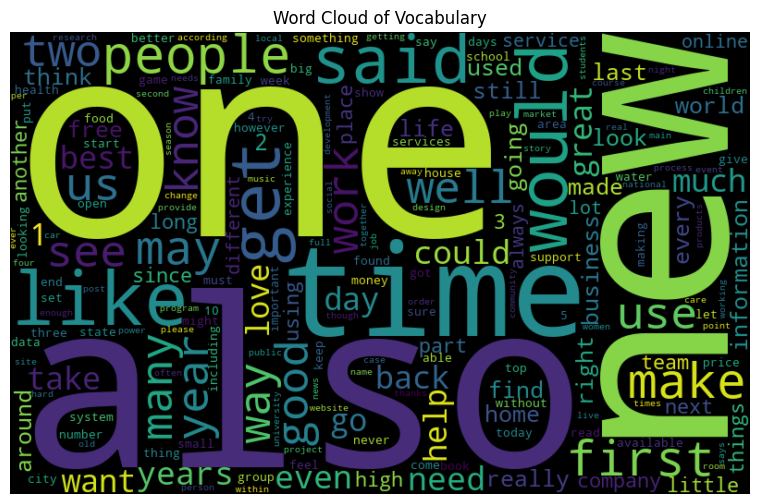

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(fdist)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Vocabulary")
plt.show()

<Axes: title={'center': 'Top 30 Most Frequent Words'}, xlabel='Samples', ylabel='Counts'>

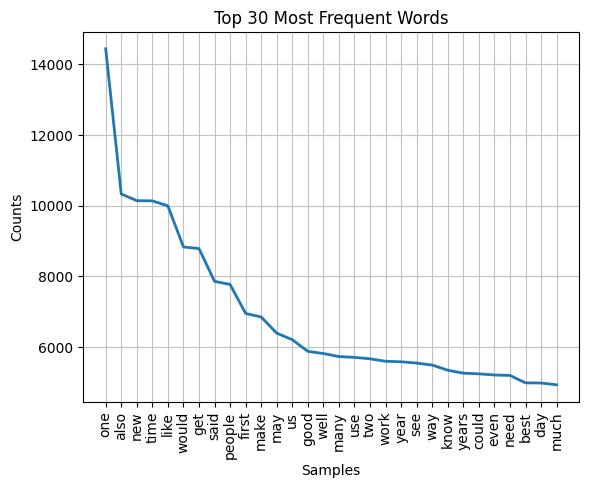

In [11]:
# Plotting the frequency distribution of the most common words
fdist.plot(30,  title="Top 30 Most Frequent Words")

Number of documents: 9598
Average context length: 321.12 tokens
Average question length: 6.81 tokens
Vocabulary size: 128313


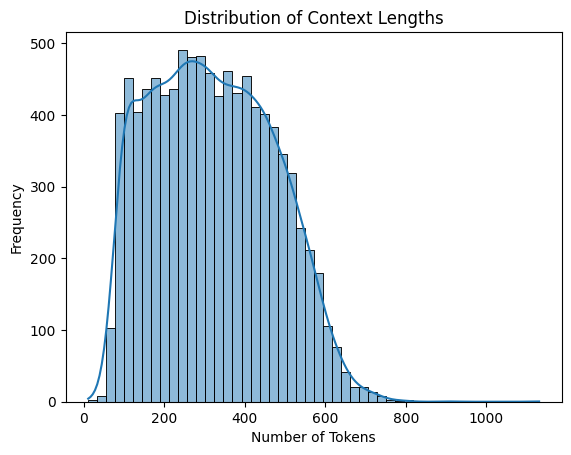

In [12]:
# Print statistics
print(f"Number of documents: {len(train_df)}")
print(f"Average context length: {sum(context_lengths)/len(context_lengths):.2f} tokens")
print(f"Average question length: {sum(question_lengths)/len(question_lengths):.2f} tokens")
print(f"Vocabulary size: {len(vocab)}")

# Plot distribution of context lengths
sns.histplot(context_lengths, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

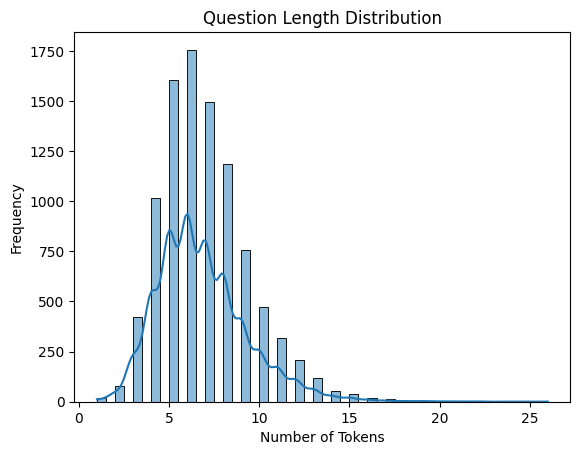

In [13]:
sns.histplot(question_lengths, bins=50, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# 🧹 Data Cleaning

In [14]:
# first entry in train dataset as table without truncation
pd.set_option('display.max_colwidth', None)
train_df.head(1)

,context,question,answer
0,"Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption of protected substrate cropping, improved genetics and an expanding geographic footprint have all helped put Aussie berries on a positive trajectory.\n“We are seeing a real transition point. Broad industry interest and a strong commercial appetite for export market development combined with the potential to capitalise on existing trade agreements and build new trade partnerships has created this perfect environment for growth.”\nHigh-income countries across Europe, North America and Northern Asia have been identified as having a palate for Australian grown berries with more than 4244 tonnes of fresh berries exported in the last financial year alone.\nThe strategy identified the best short-term prospect markets for the Australian blackberry and raspberry industry as Hong Kong, Singapore, The United Arab Emirates and Canada. The strongest short-term trade options identified for the strawberry sector were Thailand, Malaysia, New Zealand and Macau.\nThe strategy focuses heavily on growing the existing strawberry export market from 4 per cent to at least 8 per cent of national production by volume, in markets with a capacity and willingness to pay a premium for quality fruit. For raspberries and blackberries, the sectors aim to achieve a 5 per cent boost in exports assessed by volume across identified markets by 2021.\nTasmanian raspberry exporter Nic Hansen said Australia offers some of the sweetest and most attractive berries in the world, and this combined with our stringent food safety standards across all stages of the supply chain puts growers in a solid position.\n“We have a great product, we are hungry to expand trade and now with this new plan in place, we have a clear roadmap towards driving growth,” Mr Hansen said.\nHe said it is exciting to see new export market prospects for raspberries: “The more options we have for export the better. Now we just have to get on with the job of ensuring industry has all the tools it needs, such as supporting data and relationship building opportunities, to thrive in new markets.”\nThis project was commissioned by Hort Innovation, and developed by market analysts and research consultants Auspex Strategic Advisory and AgInfinity. Hort Innovation will work now with berry sectors to determine levy-funded activities to support trade.\nSee a summary of the strategy on the Hort Innovation website.\nFor more information on the berry industries, refer to the Horticulture Statistics Handbook and the Strategic Investment Plans for strawberries, raspberries and blackberries. Growers seeking more information should email trade@horticulture.com.au",What is the Berry Export Summary 2028 and what is its purpose?,"The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors’ current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over t

In [15]:
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text, preserve_question_words=False):
    """
    Clean and preprocess text by removing punctuation, stopwords, and optionally preserving question words.
    """
    # Define question words to preserve
    question_words = {"what", "where", "when", "why", "how", "who", "which"}
    
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    
    # Lemmatize, remove punctuation, and stopwords
    if preserve_question_words:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and (word not in stop_words or word in question_words)]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# Initialize tqdm for pandas to show progress
tqdm.pandas(desc="Cleaning Text")
# Clean the training set
train_df['context'] = train_df['context'].progress_apply(lambda x: clean_text(x))
train_df['question'] = train_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
train_df['answer'] = train_df['answer'].progress_apply(lambda x: clean_text(x))
# Clean the test set
test_df['context'] = test_df['context'].progress_apply(lambda x: clean_text(x))
test_df['question'] = test_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
test_df['answer'] = test_df['answer'].progress_apply(lambda x: clean_text(x))

Cleaning Text: 100%|██████████| 2399/2399 [00:00<00:00, 5752.38it/s]


In [19]:
train_df.head(1)

,context,question,answer
0,caption tasmanian berry grower nic hansen showing macau chef antimo merone around property part export engagement activity rise rise australian strawberry raspberry blackberry industry seen sector redouble international trade focus release dedicated export plan grow global presence next 10 year driven significant grower input berry export summary 2028 map sector current position want market next step hort innovation trade manager jenny van de meeberg said value volume raspberry blackberry export rose 100 per cent 2016 said australian strawberry industry experienced similar success almost 30 per cent rise export volume 26 per cent rise value period australian berry sector firm position moment said production adoption protected substrate cropping improved genetics expanding geographic footprint helped put aussie berry positive trajectory seeing real transition point broad industry interest strong commercial appetite export market development combined potential capitalise existing trade agreement build new trade partnership created perfect environment country across europe north america northern asia identified palate australian grown berry 4244 tonne fresh berry exported last financial year alone strategy identified best prospect market australian blackberry raspberry industry hong kong singapore united arab emirate canada strongest trade option identified strawberry sector thailand malaysia new zealand macau strategy focus heavily growing existing strawberry export market 4 per cent least 8 per cent national production volume market capacity willingness pay premium quality fruit raspberry blackberry sector aim achieve 5 per cent boost export assessed volume across identified market tasmanian raspberry exporter nic hansen said australia offer sweetest attractive berry world combined stringent food safety standard across stage supply chain put grower solid position great product hungry expand trade new plan place clear roadmap towards driving growth mr hansen said said exciting see new export market prospect raspberry option export better get job ensuring industry tool need supporting data relationship building opportunity thrive new project commissioned hort innovation developed market analyst research consultant auspex strategic advisory aginfinity hort innovation work berry sector determine activity support trade see summary strategy hort innovation website information berry industry refer horticulture statistic handbook strategic investment plan strawberry raspberry blackberry grower seeking information email trade,what berry export summary 2028 what purpose,berry export summary 2028 dedicated export plan australian strawberry raspberry blackberry industry map sector current position want market next step purpose plan grow global presence next 10 year


# 💬 Word Embedding (Word2Vec - questions)

In [20]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

# Tokenize the questions into words
train_df['tokenized_question'] = train_df['question'].apply(lambda x: word_tokenize(x.lower()))

vector_size = 5 # Size of the word vectors

# Train the Word2Vec model with optimized parameters for better embedding quality
word2vec_model = Word2Vec(
    sentences=train_df['tokenized_question'], 
    vector_size=vector_size, 
    window=10,  # Increase the context window size
    min_count=2,  # Ignore words that appear less frequently
    workers=4, 
    sg=1,  # Use skip-gram model for better performance on smaller datasets
    hs=0,  # Use negative sampling
    negative=10,  # Number of negative samples
    epochs=20  # Train for more epochs
)


In [21]:
# Function to get the average word embedding for a question
def get_average_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are found
    return np.mean(vectors, axis=0)

# Generate sentence embeddings for the questions
train_df['question_embedding'] = train_df['tokenized_question'].apply(lambda x: get_average_embedding(x, word2vec_model))

# Stack embeddings into a matrix
question_embeddings = np.stack(train_df['question_embedding'].values)
question_embeddings.shape

(9598, 5)

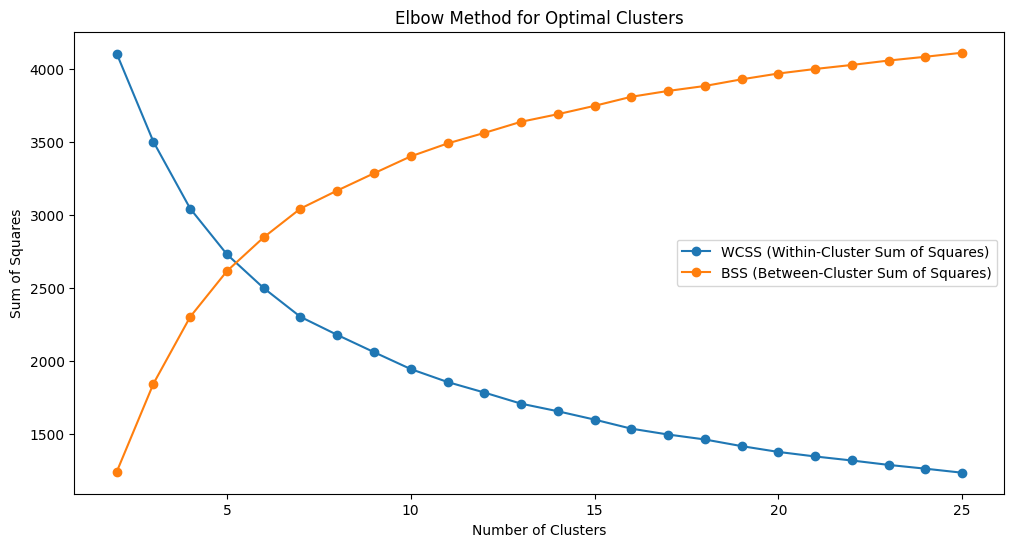

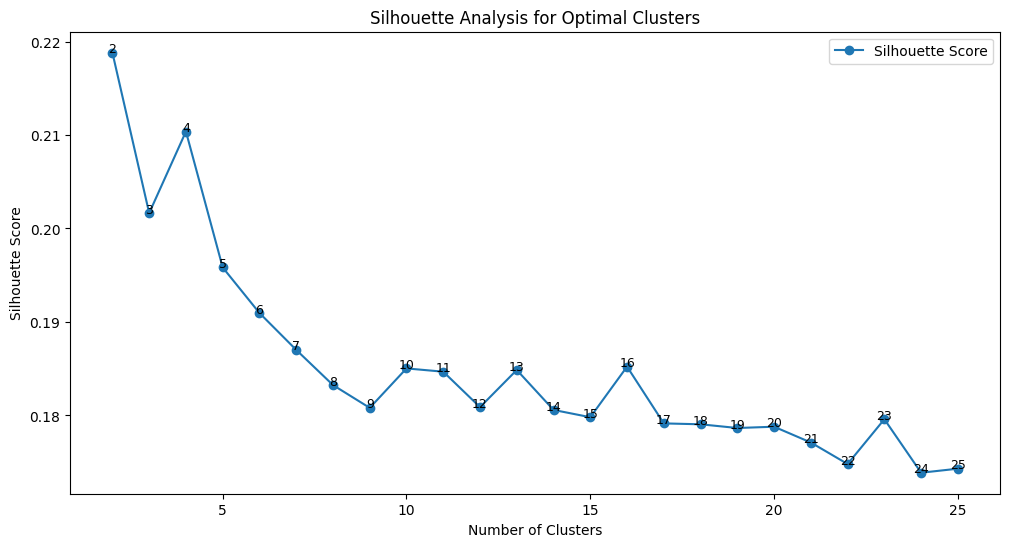

In [22]:
from sklearn.metrics import silhouette_score

# Function to find the optimal number of clusters using the Elbow Method and Silhouette Analysis
def find_optimal_clusters(embeddings, max_clusters=10):
    wcss = []  # Within-Cluster Sum of Squares
    bss = []  # Between-Cluster Sum of Squares
    silhouette_scores = []  # Silhouette Scores
    cluster_range = range(2, max_clusters + 1)
    
    # Calculate Total Sum of Squares (TSS)
    tss = np.sum((embeddings - np.mean(embeddings, axis=0))**2)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)
        
        # Calculate WCSS
        wcss.append(kmeans.inertia_)
        
        # Calculate BSS
        bss.append(tss - kmeans.inertia_)
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Plot Elbow Method for WCSS and BSS
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, wcss, marker='o', label='WCSS (Within-Cluster Sum of Squares)')
    plt.plot(cluster_range, bss, marker='o', label='BSS (Between-Cluster Sum of Squares)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squares')
    plt.title('Elbow Method for Optimal Clusters')
    plt.legend()
    plt.show()
    
    # Plot Silhouette Scores
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
    # Plot the cluster number above each point
    for i, score in enumerate(silhouette_scores):
        plt.text(cluster_range[i], score, str(cluster_range[i]), fontsize=9, ha='center')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal Clusters')
    plt.legend()
    plt.show()
    
    return wcss, bss, silhouette_scores

# Find the optimal number of clusters
wcss, bss, silhouette_scores = find_optimal_clusters(question_embeddings, max_clusters=25)

/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



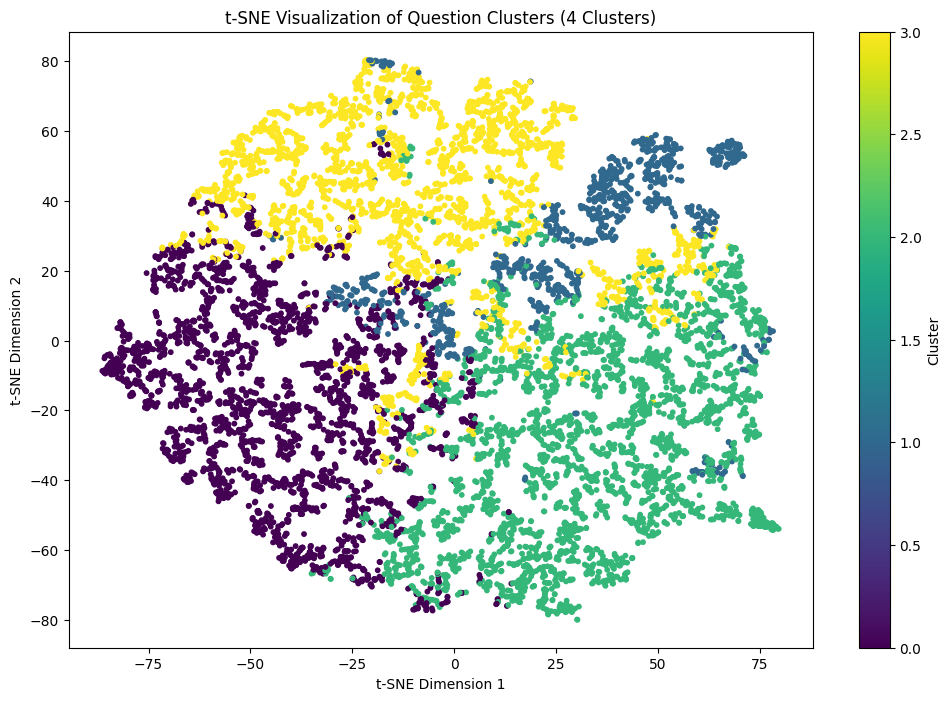

Cluster 0:
what (1275), who (1269), when (179), first (162), author (152), why (135), game (134), new (131), how (127), event (119)


Cluster 1:
what (1000), service (197), feature (193), offered (115), offer (98), amenity (88), type (71), provided (68), available (68), hotel (61)


Cluster 2:
what (3046), context (664), according (382), mentioned (325), author (279), main (245), when (149), how (145), used (138), benefit (130)


Cluster 3:
what (2169), according (274), who (255), purpose (246), main (135), how (135), new (132), role (100), program (86), context (85)




In [25]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

n_clusters = 4

# Perform K-Means clustering with 7 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_df['cluster'] = kmeans.fit_predict(question_embeddings)

# Reduce dimensions of question embeddings using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
question_embeddings_2d = tsne.fit_transform(question_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(question_embeddings_2d[:, 0], question_embeddings_2d[:, 1], c=train_df['cluster'], cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title(f't-SNE Visualization of Question Clusters ({n_clusters} Clusters)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Function to extract topics for each cluster
def get_cluster_topics(df, cluster_col, text_col, top_n=10):
    cluster_topics = {}
    for cluster_id, group in df.groupby(cluster_col):
        # Tokenize all questions in the cluster
        all_words = [word for question in group[text_col] for word in word_tokenize(question.lower())]
        # Count word frequencies
        word_freq = Counter(all_words)
        # Get the top N most common words
        cluster_topics[cluster_id] = word_freq.most_common(top_n)
    return cluster_topics

# Get topics for each cluster
topics = get_cluster_topics(train_df, cluster_col='cluster', text_col='question', top_n=10)

# Display topics for each cluster
for cluster_id, words in topics.items():
    print(f"Cluster {cluster_id}:")
    print(", ".join([f"{word} ({count})" for word, count in words]))
    print("\n")

In [26]:
import plotly.express as px
from sklearn.decomposition import PCA
# Reduce dimensions of question embeddings to 3D using PCA
pca = PCA(n_components=3)
question_embeddings_3d = pca.fit_transform(question_embeddings)


# Prepare a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PCA Dimension 1': question_embeddings_3d[:, 0],
    'PCA Dimension 2': question_embeddings_3d[:, 1],
    'PCA Dimension 3': question_embeddings_3d[:, 2],
    'Cluster': train_df['cluster'],
    'Question': train_df['question']
})
# Create an interactive 3D scatter plot with a larger figure size
fig = px.scatter_3d(
    visualization_df,
    x='PCA Dimension 1',
    y='PCA Dimension 2',
    z='PCA Dimension 3',
    color='Cluster',
    hover_data=['Question'],  # Show the question on hover
    title='Interactive 3D Visualization of Question Clusters',
    width=1200,  # Set the width of the plot
    height=1000   # Set the height of the plot
)

# Show the plot
fig.show()

# 📝 Sentence embedding (all-MiniLM-L6-v2 on context)

In [27]:
!pip install sentence-transformers

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.6 MB/s eta 0:00:00a 0:00:01
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.9 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings. 
model = SentenceTransformer('all-MiniLM-L6-v2')

sentence_embeddings = model.encode(train_df['context'].tolist(), convert_to_tensor=True, show_progress_bar=True)

Finding clusters: 100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


AttributeError: 'DataFrame' object has no attribute 'append'

Finding clusters: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

Number of clusters found: 45


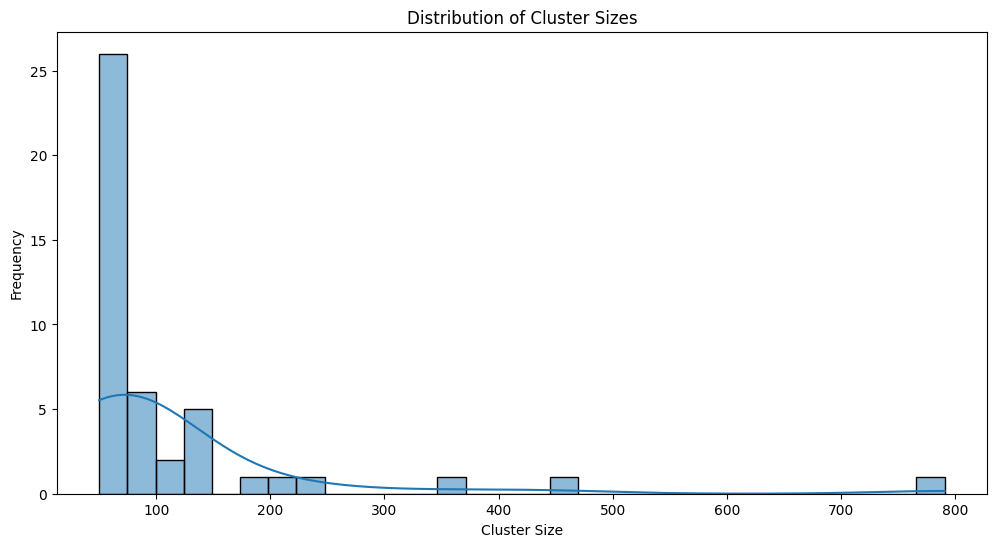

In [ ]:
# Perform community detection on the sentence embeddings
clusters = util.community_detection(sentence_embeddings, min_community_size=30, threshold=0.6, show_progress_bar=True)

print("Number of clusters found:", len(clusters))

# plot the distribution of cluster sizes
cluster_sizes = [len(cluster) for cluster in clusters]
plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes, kde=True)
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.show()

In [39]:
cluster_sizes

[791,
 447,
 351,
 247,
 221,
 175,
 148,
 137,
 137,
 133,
 125,
 101,
 101,
 88,
 86,
 85,
 80,
 80,
 75,
 72,
 71,
 70,
 70,
 67,
 67,
 66,
 64,
 64,
 64,
 62,
 61,
 58,
 57,
 56,
 55,
 53,
 53,
 53,
 52,
 51,
 51,
 50,
 50,
 50,
 50]

In [ ]:
#Print all clusters with the members
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", train_df['context'].iloc[sentence_id])